In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import sklearn.tree as tree
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics
from subprocess import call
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [110]:
#Reading file
titanic=pd.read_csv('train.csv')

In [111]:
#Inspecting data
print(titanic.describe())
print(titanic.info())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data colu

### DATA CLEANING

In [112]:
#Filling nans in age column with mean age of people from the same sex and Pclass
grouped=titanic.groupby(['Sex', 'Pclass'])
def cleaning(group):
    return group.fillna(group.mean())
titanic['Age']=grouped['Age'].transform(cleaning)

In [113]:
#Filling nans values in embarked column with the most frequent value
print(titanic['Embarked'].value_counts())
titanic['Embarked']=titanic['Embarked'].fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [114]:
#Dropping unnecessary columns - PassengerID, ticket and cabin
titanic.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

### FEATURE ENGINEERING

In [115]:
#Adding column with information about family size
titanic['FamilySize']= titanic['SibSp']+titanic['Parch']+1

In [116]:
#Adding column IsAlone: 0 - travelling with family, 1 - travelling alone
titanic['IsAlone']=1
titanic['IsAlone'].loc[titanic['FamilySize']>1]=0

In [117]:
#Extracting titles from name column and creating column Title
titanic['Title']=titanic['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titanic['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs'}, inplace=True)
titanic['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Countess', 'Lady', 'Don', 'Capt', 'Sir'], 'Special', inplace=True)

In [118]:
#Creating column with age group
titanic['GroupAge']=pd.cut(titanic['Age'], 4, labels=False)

In [119]:
#Creating column with fare group
titanic['GroupFare']=pd.qcut(titanic['Fare'],4, labels=False)

In [120]:
#Dropping unnecessary columns
titanic.drop(['FamilySize', 'Name', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1, inplace=True)

In [121]:
#Creating dummy variables for categorical columns
titanic=pd.get_dummies(titanic, columns=['Pclass', 'Sex', 'Embarked', 'Title'], drop_first=True)

In [122]:
#Inspecting data
print(titanic.head())
print(titanic.describe())
print(titanic.info())

   Survived  IsAlone  GroupAge  GroupFare  Pclass_2  Pclass_3  Sex_male  \
0         0        0         1          0         0         1         1   
1         1        0         1          3         0         0         0   
2         1        1         1          1         0         1         0   
3         1        0         1          3         0         0         0   
4         0        1         1          1         0         1         1   

   Embarked_Q  Embarked_S  Title_Miss  Title_Mr  Title_Mrs  Title_Special  
0           0           1           0         1          0              0  
1           0           0           0         0          1              0  
2           0           1           1         0          0              0  
3           0           1           0         0          1              0  
4           0           1           0         1          0              0  
         Survived     IsAlone    GroupAge   GroupFare    Pclass_2    Pclass_3  \
count  891.0

### SPLITTING DATASET INTO TRAIN AND TEST

In [123]:
#Extract feature columns and target column
X=titanic.drop('Survived', axis=1)
y=titanic['Survived']

In [124]:
#split dataset to train and test sample
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

### BUILDING AND EVALUATING DECISION TREES

In [125]:
#function which makes prediction on given model and return auc score
def prediction_auc(X, y_true):
    y_pred=decisiontree.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
    result = auc(false_positive_rate, true_positive_rate)
    return result

#plotting results for train and test data depending on teste variable
def plotting(x, x_name, list_auc_train, list_auc_test):
    plt.plot(x, list_auc_train, label='train')    
    plt.plot(x, list_auc_test, label='test')
    plt.legend()
    plt.xlabel(x_name)
    plt.ylabel('AUC score')
    plt.show()

#function which return image of tree's structure
def visualizing_tree(tree, name):
    export_graphviz(tree, out_file='tree.dot',feature_names = X_train.columns.tolist(), class_names=['Not Survived', 'Survived'], rounded = True, proportion = False, precision = 2, filled = True)
    call(['dot', '-Tpng', 'tree.dot', '-o', name, '-Gdpi=600'])
    return Image(filename = name)

#### . TUNING MAX DEPTH

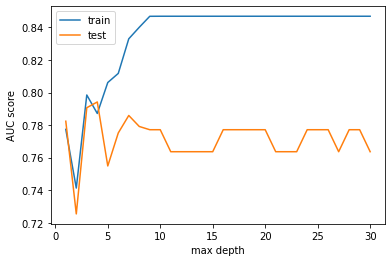

In [126]:
max_depths=range(1,31) #creating list of values to check

list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of max depth
for max_depth in max_depths:
    decisiontree=DecisionTreeClassifier(max_depth=max_depth)
    decisiontree.fit(X_train,y_train)
    
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(max_depths, 'max depth', list_auc_train, list_auc_test)

In [127]:
#buliding tree with max depth=4
decisiontree_depth_4=DecisionTreeClassifier(max_depth=4)
decisiontree_depth_4.fit(X_train,y_train)
y_pred=decisiontree_depth_4.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)

AUC score:  0.7942084942084942


[Text(181.8310344827586, 195.696, 'X[9] <= 0.5\ngini = 0.469\nsamples = 712\nvalue = [444, 268]'),
 Text(92.35862068965517, 152.208, 'X[4] <= 0.5\ngini = 0.426\nsamples = 293\nvalue = [90, 203]'),
 Text(46.179310344827584, 108.72, 'X[11] <= 0.5\ngini = 0.185\nsamples = 155\nvalue = [16, 139]'),
 Text(23.089655172413792, 65.232, 'X[5] <= 0.5\ngini = 0.07\nsamples = 138\nvalue = [5, 133]'),
 Text(11.544827586206896, 21.744, 'gini = 0.075\nsamples = 128\nvalue = [5, 123]'),
 Text(34.63448275862069, 21.744, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(69.26896551724138, 65.232, 'X[3] <= 0.5\ngini = 0.457\nsamples = 17\nvalue = [11, 6]'),
 Text(57.72413793103448, 21.744, 'gini = 0.496\nsamples = 11\nvalue = [5, 6]'),
 Text(80.81379310344828, 21.744, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(138.53793103448277, 108.72, 'X[2] <= 2.5\ngini = 0.497\nsamples = 138\nvalue = [74, 64]'),
 Text(115.44827586206895, 65.232, 'X[7] <= 0.5\ngini = 0.497\nsamples = 115\nvalue = [53, 62]'),


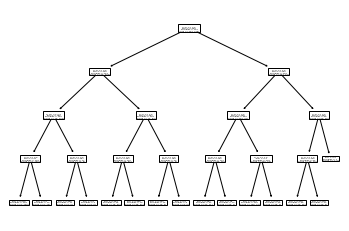

In [133]:
#visualizing tree structure
tree.plot_tree(decisiontree_depth_4 )

#### . TUNING MIN SAMPLES SPLIT

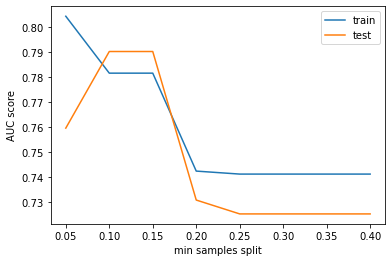

In [79]:
min_samples_splits=np.linspace(0.05,0.4,8) #creating list of values to check
list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of min samples split
for min_samples_split in min_samples_splits:
    decisiontree=DecisionTreeClassifier(min_samples_split=min_samples_split)
    decisiontree.fit(X_train,y_train)
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(min_samples_splits, 'min samples split', list_auc_train, list_auc_test)

AUC score:  0.7902187902187902


[Text(196.94117647058823, 205.35999999999999, 'X[9] <= 0.5\ngini = 0.469\nsamples = 712\nvalue = [444, 268]'),
 Text(118.16470588235295, 181.2, 'X[4] <= 0.5\ngini = 0.426\nsamples = 293\nvalue = [90, 203]'),
 Text(78.7764705882353, 157.04, 'X[11] <= 0.5\ngini = 0.185\nsamples = 155\nvalue = [16, 139]'),
 Text(59.082352941176474, 132.88, 'X[5] <= 0.5\ngini = 0.07\nsamples = 138\nvalue = [5, 133]'),
 Text(39.38823529411765, 108.72, 'X[2] <= 2.5\ngini = 0.075\nsamples = 128\nvalue = [5, 123]'),
 Text(19.694117647058825, 84.56, 'gini = 0.097\nsamples = 59\nvalue = [3, 56]'),
 Text(59.082352941176474, 84.56, 'gini = 0.056\nsamples = 69\nvalue = [2, 67]'),
 Text(78.7764705882353, 108.72, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(98.47058823529412, 132.88, 'gini = 0.457\nsamples = 17\nvalue = [11, 6]'),
 Text(157.5529411764706, 157.04, 'X[2] <= 2.5\ngini = 0.497\nsamples = 138\nvalue = [74, 64]'),
 Text(137.85882352941178, 132.88, 'X[7] <= 0.5\ngini = 0.497\nsamples = 115\nvalue = [

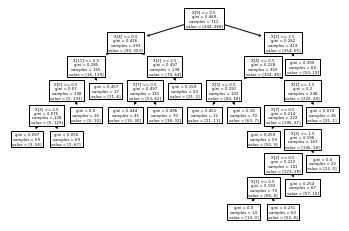

In [137]:
#building tree with min samples split=0.1 and visualizing its structure
decisiontree_split_01=DecisionTreeClassifier(min_samples_split=0.1)
decisiontree_split_01.fit(X_train,y_train)
y_pred=decisiontree_split_01.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)
tree.plot_tree(decisiontree_split_01)

#### . TUNING MIN SAMPLES LEAF

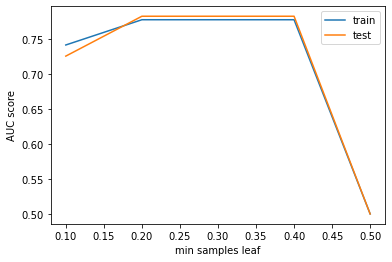

In [81]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True) #creating list of values to check
list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of min samples leaf
for min_samples_leaf in min_samples_leafs:
    decisiontree=DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    decisiontree.fit(X_train,y_train)
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(min_samples_leafs, 'min samples leaf', list_auc_train, list_auc_test)

AUC score:  0.7823680823680824


[Text(167.4, 181.2, 'X[9] <= 0.5\ngini = 0.469\nsamples = 712\nvalue = [444, 268]'),
 Text(83.7, 108.72, 'X[8] <= 0.5\ngini = 0.426\nsamples = 293\nvalue = [90, 203]'),
 Text(41.85, 36.23999999999998, 'gini = 0.408\nsamples = 147\nvalue = [42, 105]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.441\nsamples = 146\nvalue = [48, 98]'),
 Text(251.10000000000002, 108.72, 'X[2] <= 1.5\ngini = 0.262\nsamples = 419\nvalue = [354, 65]'),
 Text(209.25, 36.23999999999998, 'gini = 0.208\nsamples = 263\nvalue = [232, 31]'),
 Text(292.95, 36.23999999999998, 'gini = 0.341\nsamples = 156\nvalue = [122, 34]')]

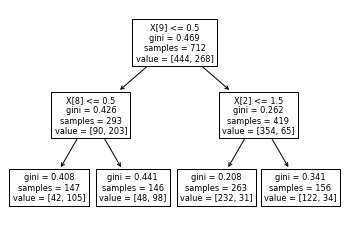

In [139]:
#building tree with min samples leaf=0.2 and visualizing its structure
decisiontree_leaf_02=DecisionTreeClassifier(min_samples_leaf=0.2)
decisiontree_leaf_02.fit(X_train,y_train)
y_pred=decisiontree_leaf_02.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)
tree.plot_tree(decisiontree_leaf_02)

# . BUILDING AND EVALUATING RANDOM FOREST

In [83]:
#Random Forest
randomforest=RandomForestClassifier() #initializing model
ne = np.arange(1,20) 
param_grid = {'n_estimators' : ne} #parameters grid

rf_cv = GridSearchCV(randomforest, param_grid=param_grid, cv=5) #performing gridsearchcv
rf_cv.fit(X, y)
print('Best estimator', rf_cv.best_params_)

Best estimator {'n_estimators': 15}


In [84]:
#Random Forest
randomforest=RandomForestClassifier() #initializing model
ne = np.arange(1,20) 
param_grid = {'n_estimators' : ne} #parameters grid

rf_cv = GridSearchCV(randomforest, param_grid=param_grid, cv=5) #performing gridsearchcv
rf_cv.fit(X, y)
print('Best estimator', rf_cv.best_params_)

Best estimator {'n_estimators': 10}


In [141]:
#building tree with min samples leaf=0.2 and visualizing its structure
decisiontree_leaf_02=DecisionTreeClassifier(min_samples_leaf=0.2)
decisiontree_leaf_02.fit(X_train,y_train)
y_pred=decisiontree_leaf_02.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)


AUC score:  0.7823680823680824
